<a href="https://colab.research.google.com/github/Jinyoung9393/AIFFEL_ONLINE_QUEST/blob/master/MQ04/Main_Quest04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# X-ray 사진 폐렴 판독기를 만들어보자.
### 메인퀘스트 시작하기 전 노드에서 cnn으로 80% 정도 되는 정확도의 판독기를 만들어 보았다.
### 전 노드에서 만들었었던 판독기를 바탕으로 더 좋은 성능을 가진 판독기로, 그것을 Resnet으로 다시 구현해보자.

# Set-up
패키지와 라이브러리를 임포트하고 필요한 변수들을 생성한다.

In [ ]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import warnings
from IPython.display import Image
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


# 데이터 전처리
test, train, val 폴더에 있는 normal, pneumonia data를 가져온다.
기존 판독기보다 좋은 판독기를 만들기 위해서 augmentation을 사용한다.
augmentation은 좌우반전과 노이즈 주기를 사용해보려 한다.

In [ ]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


val에 들어있는 데이터가 16개 밖에 없기 때문에 train 데이터를 val에 추가해주려한다. 비율은 train : val = 80 : 20으로 진행한다.

In [ ]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


normal 데이터와 pneumonia 데이터의 개수를 확인해보자.

In [ ]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


각 레이블에 들어갈 데이터의 개수가 차이가 나기 때문에 차후에 가중치의 영향을 조정하여 imbalance를 해결하면 된다.
test와 val 셋은 평가를 위한 데이터이기 때문에 imbalance한 데이터여도 상관없다.


# tf.data 인스턴스 생성
tf.data는 tensorflow에서 학습시킬 때 mini-batch로 작업하려한다.
mini-batch는 최적화를 할 때 한번에 몇개에 데이터를 가지고 하는 지를 나타내고 한꺼번에 많은 양의 데이터를 학습하지 않고 단위 별로 쪼개서 하는 것을 말한다.
데이터가 많아질 때 길어지는 시간이나 데이터의 손실을 줄이기 위해 사용한다.

In [ ]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


파일 경로에 라벨의 이름이 포함되어 있기 때문에 라벨 데이터를 만들어주는 함수를 만든다.

In [ ]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

학습시킬 이미지의 사이즈를 통일 시키고 효율적인 사용을 위해 이미지 사이즈를 줄인다.

In [ ]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label



train 데이터와 val 데이터의 셋을 만들고 autotune 변수를 활용해 데이터를 빠르게 처리 할 수 있도록 한다.

In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지가 잘 들어있는지 확인해본다.

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


test 데이터 셋도 만든다.

In [ ]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


데이터를 효율적으로 읽고 전처리 및 데이터 증강 단계를 구성하고 데이터를 배치로 나누는 등 다양한 데이터 처리 작업을 수행할 수 있는 tf.data 파이프라인을 사용하고 prepare_for_training() 함수를 정의해서 데이터를 변환시켜 주려한다.<br>
shuffle()은 데이터를 무작위로 섞는 메서드이다.<br>
repeat()은 tf.data 파이프라인에서 데이터셋을 여러 번 반복하는 데 사용된다.<br>
batch()는 BATCH_SIZE에서 정한만큼의 배치로 주어진다.<br>
prefetch() tf.data 파이프라인에서 다음 배치 데이터를 사전에 메모리에 로드하여 GPU 또는 CPU의 작업량을 최대로 활용하는 데 사용된다.<br>


data의 량이 적기 때문에 prepare_for_training() 함수에 좌우를 반전하고 노이즈를 만드는 내용을 추가한다.

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


# 데이터 시각화
train의 batch 중 첫번째 배치를 추출하여 시각화한다.

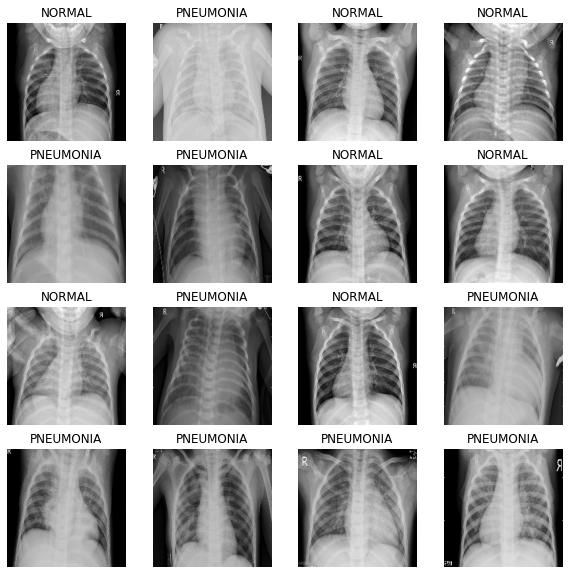

In [ ]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Resnet-18 구현
ResNet의 가장 큰 특징은 skip connection이다.일반적인 네트워크 구조에서는 모든 layer가 이전 layer의 출력을 입력으로 받아 처리하지만, ResNet에서는 skip connection을 추가하여 layer를 건너 뛰어 이전 출력을 바로 다음 layer로 보낼 수 있다.<br>
skip connection이 구현된 함수 residual_module을 정의한다.<br>
skip connection을 구성하기 위해서 connection을 통해서 합해지는 feature map들의 가로x세로x채널 사이즈가 맞아야 한다<br>

In [ ]:
def residual_module(input_layer, n_filters, stride=1):
    merge_input = input_layer
    # if문에서는 채널 사이즈가 동일한지 확인하고, 만일 동일하지 않다면 1x1 convolution을 통해서 채널 사이즈를 맞춰 준다.
    if input_layer.shape[-1] != n_filters:
        merge_input = keras.layers.Conv2D(n_filters, (1,1), padding='same', activation='relu')(input_layer)

    # stride  값이 1이 아닐 경우 feature map의 크기가 줄어듦으로 skip connection을 연결할 때 크기를 동일하게 맞춰줌
    if stride == 2:
        # feature map 크기가 줄어들 때는 filter의 수를 증가시켜야함
        out_layer = keras.layers.Conv2D(n_filters*2, (3,3), padding='same', activation='relu', strides=stride)(input_layer)
        merge_input = keras.layers.Conv2D(n_filters*2, (1,1), padding='same', activation='relu', strides=stride)(merge_input)

    else:
        conv1 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu', strides=stride)(input_layer)
        conv2 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='linear')(conv1)
        out_layer = keras.layers.Add()([conv2, merge_input])
        out_layer = keras.layers.Activation('relu')(out_layer)

    return out_layer



기본적인 Residual module을 만들고 모델을 더 깊게 만들기 위해 여러 개의 residual module을 연결한다.

In [ ]:
def residual_stage(input_layer, n_filters, n_blocks, stride=1):
    # 첫 번째 residual module에만 stride 값을 지정
    out_layer = residual_module(input_layer, n_filters, stride=stride)

    for i in range(n_blocks-1):
        out_layer = residual_module(out_layer, n_filters)

    return out_layer

In [ ]:
input_layer = keras.layers.Input(shape=(180, 180, 3))
n_filters = 64
conv1 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(input_layer)
pool1 = keras.layers.MaxPooling2D((2,2))(conv1)

# 각 stage에서 사용되는 residual module의 개수를 정의
n_blocks_stage1 = 3
n_blocks_stage2 = 3
n_blocks_stage3 = 3
n_blocks_stage4 = 5

# 각 stage에 맞게 residual_stage 함수를 호출하여 연결해준다.
stage1 = residual_stage(pool1, n_filters, n_blocks=n_blocks_stage1)
stage2 = residual_stage(stage1, n_filters*2, n_blocks=n_blocks_stage2, stride=2)
stage3 = residual_stage(stage2, n_filters*4, n_blocks=n_blocks_stage3, stride=2)
stage4 = residual_stage(stage3, n_filters*8, n_blocks=n_blocks_stage4, stride=2)

# global average pooling layer를 적용하여 fully connected layer 대신 분류 layer로 바로 연결한다.
global_pool = keras.layers.GlobalAveragePooling2D()(stage4)
output_layer = keras.layers.Dense(1, activation='softmax')(global_pool)

model = keras.models.Model(input_layer, output_layer)
print(model)
model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 180, 180, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 90, 90, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 90, 90, 64)   36928       max_pooling2d[0][0]              
______________________________________________________________________________________________

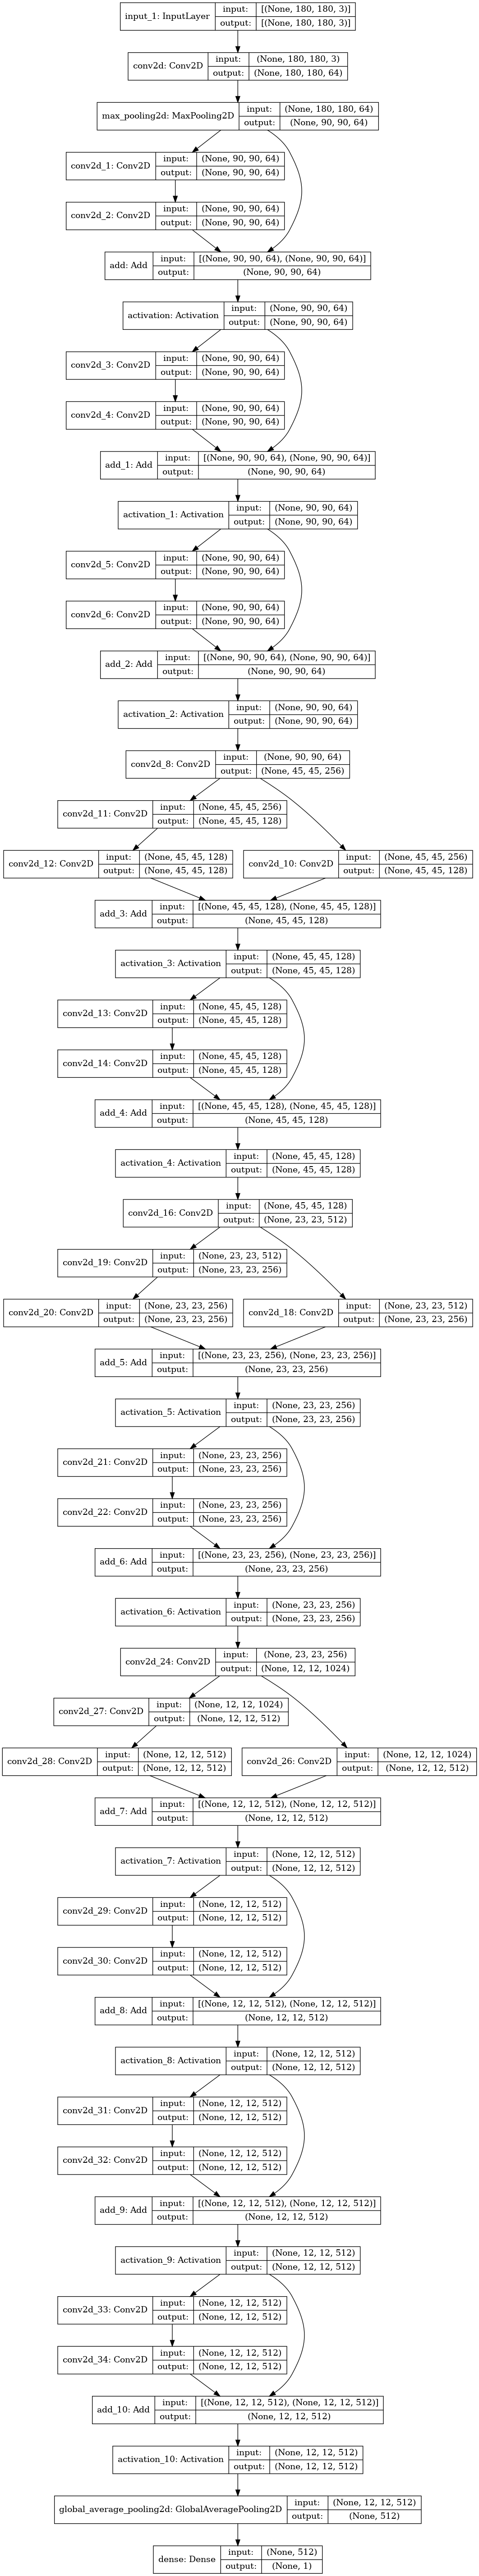

In [ ]:
plot_model(model, show_shapes=True, to_file='residual_module.png')

# 데이터 imbalance 처리
normal데이터와 Pneumonia 데이터 개수가 차이가 나기 때문에 imbalance를 처리해야 한다.<br>
이런 상황에서 모델은 데이터가 많은 클래스에 치우쳐 학습하게 되어 전체 성능이 저하될 수 있다.<br>
문제해결을 위해 Weight balancing를 사용하려 한다.<br>

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


#  모델 훈련
이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택한다.<br>
라벨이 2개 밖에 없기 때문에 "binary_cross entropy" loss를 사용하고 옵티마이저는 adam을 사용한다.<br>
성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용한다.

In [ ]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

모델을 fit한다.

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 80s 245ms/step - loss: 1.1402 - accuracy: 0.7443 - precision: 0.7443 - recall: 1.0000 - val_loss: 0.6936 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 63s 242ms/step - loss: 0.6926 - accuracy: 0.7450 - precision: 0.7450 - recall: 1.0000 - val_loss: 0.6929 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 63s 243ms/step - loss: 0.6939 - accuracy: 0.7435 - precision: 0.7435 - recall: 1.0000 - val_loss: 0.6935 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 63s 241ms/step - loss: 0.6931 - accuracy: 0.7445 - precision: 0.7445 - recall: 1.0000 - val_loss: 0.6933 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 63s 242ms/step - loss: 0.6935 - accura

# 결과 확인
그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 확인해본다.

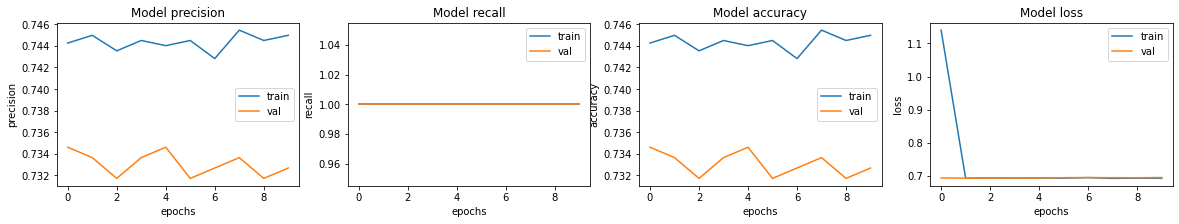

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력한다.

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 115ms/step - loss: 0.6941 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6941215991973877,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


# 회고

# 프로젝트 평가기준

## 1.모델학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.

## 2.데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.

## 3.Resnet 모델을 구현하였다.



1. 모델학습이 오류없이 수렴되긴 하지만 시각화와 평가치를 보니 기존 모델보다 성능이 떨어진 것을 알 수 있었다. 어떤 이유인지 확인이 필요하다.

2. 데이터를 준비할 때 기존의 좌우반전 말고도 노이즈를 넣어 데이터의 양을 높였지만, 회고하기 전 자료를 찾아보니 의료분야에서는 상황에 따라 다르지만 노이즈 메서드가 쓰지 않는 것이 좋다고 한다. 이번 퀘스트로 인해 하나 더 배웠다.

3. 많은 구글링과 정보의 바다 유튜브를 통해 Resnet 모델을 구현한다고 해봤지만, 내가 만든 모델이 제대로 된 Resnet 모델이 맞는지, 맞다면 왜 에폭을 많이 돌려도 정확도가 오르지 않는지 의문이다.....

# 이번 퀘스트를 통해 느낀점

## 정확도를 올리기 위해 여러 노력을 해봤다. 데이터 전처리를 다시 해보고, Resnet 모델도 만져보고 파라미터도 수정해보았지만 그리 유의미한 결과를 얻어내지 못했다. 오히려 수정 중 오류가 발생하기도 하고 데드 커널이 생기면서 나를 힘들게 했다. 파주부처라고 불리던 내가 파주사탄,파주마구니가 되었다. 딥러닝에 대해 배운내용 중 적어도 30%는 이해했다고 생각했는데, 아주 어림도 없는 생각이었다. 이것은 공부할 때 나의 노오오오력이 굉장히 부족했기 때문에 생긴 참사라고 생각한다. 다행히 제출 마감전에 완성할 수 있었지만, 만족하지 못할 결과였다. 이번 주말은 죽었다 생각하고 여러 딥러닝 모델을 만들어보는 시간을 가져야 할 것 같다. <br>
### 어떤 멋지고 아름답고 훌륭하신 분이 제 퀘스트를 평가해주실 지 모르겠지만 제 공부의 노오오력이 아닌 해내겠다는 노오오력을 봐서라도... 이쁘게 봐주세요...